In [1]:
import pandas as pd
import numpy as np
import warnings

import string
from collections import Counter
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing

In [2]:
warnings.filterwarnings("ignore")

# read in dataset 
df = pd.read_csv("../data/final_dataset.csv")
# extact publisher name
df['news_site'] = df['publisher'].apply(lambda x: eval(x)['title'] if isinstance(x, str) else None)

# convert date to datetime format
df['date'] = pd.to_datetime(df['published date'])
df_clean = df[['news_site', 'title', 'date']]

# helper function to clean headline data
def remove_after_last_hyphen(s):
    last_hyphen_index = s.rfind(' - ')
    if last_hyphen_index != -1:
        return s[:last_hyphen_index].strip()
    return s

# transforming headlines into lists of words
df_clean['processed_title'] = df_clean['title'].str.lower()
df_clean['processed_title'] = df_clean['processed_title'].apply(remove_after_last_hyphen)
df_clean['processed_title'] = df_clean['processed_title'].str.translate(str.maketrans('', '', string.punctuation))
df_clean['processed_title'] = df_clean['processed_title'].str.split()

df_clean.head(10)

,news_site,title,date,processed_title
0,Prism,Pro-Palestine student organizers face crackdow...,2024-03-05 08:00:00+00:00,"[propalestine, student, organizers, face, crac..."
1,The Oklahoma Daily,"150 students take part in pro-Palestine, pro-I...",2024-03-08 23:20:24+00:00,"[150, students, take, part, in, propalestine, ..."
2,Tufts Daily,Students protest Kumar’s condemnation of TCU S...,2024-03-06 08:00:00+00:00,"[students, protest, kumar’s, condemnation, of,..."
3,The Amherst Student,Amherst for Palestine Demands Divestment Outsi...,2024-03-06 08:00:00+00:00,"[amherst, for, palestine, demands, divestment,..."
4,Inside Higher Ed,Columbia's protest policy less stringent than ...,2024-03-07 08:00:00+00:00,"[columbias, protest, policy, less, stringent, ..."
5,The Vanderbilt Hustler,Vanderbilt students protest for prison reform ...,2024-03-04 08:00:00+00:00,"[vanderbilt, students, protest, for, prison, r..."
6,ABC 10 News San Diego KGTV,UCSD students organize large protest in suppor...,2024-03-06 08:00:00+00:00,"[ucsd, students, organize, large, protest, in,..."
7,Harvard Crimson,Student Protesters Accuse Harvard Administrato...,2024-03-04 08:00:00+00:00,"[student, protesters, accuse, harvard, adminis..."
8,WSKG.org,Ithaca Common Council calls for ceasefire in I...,2024-03-07 08:00:00+00:00,"[ithaca, common, council, calls, for, ceasefir..."
9,Tufts Daily,Students allege police aggression at Nov. 17 p...,2024-03-07 08:00:00+00:00,"[students, allege, police, aggression, at, nov..."


(array([19783., 19797., 19814., 19828., 19844., 19858.]),
 [Text(19783.0, 0, '2024-03-01'),
  Text(19797.0, 0, '2024-03-15'),
  Text(19814.0, 0, '2024-04-01'),
  Text(19828.0, 0, '2024-04-15'),
  Text(19844.0, 0, '2024-05-01'),
  Text(19858.0, 0, '2024-05-15')])

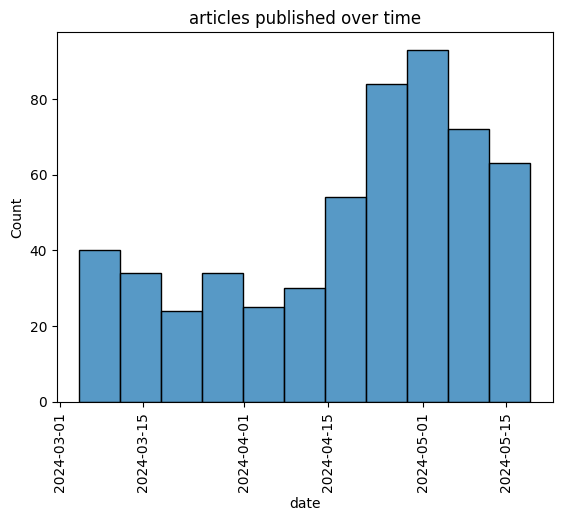

In [3]:
sns.histplot(df_clean['date'])
plt.title('articles published over time')
plt.xticks(rotation=90)

# Clustering Analysis

In [4]:
# vectorizing headlines
sentences = df_clean['processed_title'].tolist()
word2vec = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

vectors = []
for tokens in df_clean['processed_title']:
    vectors.append(np.mean([word2vec.wv[word] for word in tokens if word in word2vec.wv] or 
                           [np.zeros(word2vec.vector_size)], axis=0))
    
headline_vectors = pd.DataFrame(vectors)
headline_vectors.head(10)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.002394,0.007514,-0.002322,0.001353,-0.002273,-0.011111,0.008130,0.011406,-0.009169,-0.006564,...,0.008867,0.003113,0.002516,0.002950,0.011056,0.009802,0.003379,-0.005294,0.001685,-0.003065
1,-0.002130,0.005589,-0.001256,0.001343,0.001752,-0.011780,0.007254,0.011889,-0.008453,-0.003821,...,0.006634,0.006087,0.000782,0.001163,0.009967,0.008073,0.006589,-0.007722,0.005591,-0.002110
2,-0.007781,0.008388,-0.001894,0.000898,0.000332,-0.008022,0.007669,0.013660,-0.009402,-0.007284,...,0.011137,0.007417,0.002829,0.001248,0.014614,0.011527,0.010332,-0.008345,0.006833,-0.005100
3,-0.004071,0.005977,0.002962,-0.000771,-0.000035,-0.006641,0.001438,0.003890,-0.007065,-0.001031,...,0.005788,0.002474,0.000059,0.002072,0.003160,0.004366,0.005607,0.002097,0.001544,-0.003043
4,-0.000479,0.005490,-0.002466,-0.001468,-0.000234,-0.005836,0.004043,0.008091,-0.004513,-0.004064,...,0.005041,0.003021,0.004173,0.001469,0.007665,0.003763,0.004023,-0.001138,-0.002784,-0.002854
5,-0.002458,0.009397,-0.002374,0.004093,-0.000463,-0.014428,0.008314,0.014613,-0.014264,-0.004970,...,0.013795,0.003516,0.004748,0.001485,0.015596,0.008828,0.008594,-0.007856,0.005144,-0.003934
6,-0.005700,0.008851,-0.002524,0.003989,0.001216,-0.015370,0.007417,0.014984,-0.013157,-0.007152,...,0.013450,0.006176,0.001948,0.000209,0.016373,0.013475,0.007210,-0.007446,0.003238,-0.006859
7,-0.003700,0.006355,-0.000161,0.004824,-0.001680,-0.014620,0.010944,0.015622,-0.011836,-0.006595,...,0.014699,0.003910,0.002765,0.000422,0.014411,0.010908,0.005811,-0.006461,0.005967,-0.007041
8,-0.005587,0.006755,-0.001285,0.000437,0.001855,-0.014438,0.006661,0.015074,-0.010333,-0.004456,...,0.010338,0.004469,0.000736,-0.000639,0.012016,0.006609,0.009268,-0.011032,0.003578,-0.003787
9,-0.005485,0.010088,-0.001613,0.003789,0.003486,-0.014268,0.007202,0.015282,-0.011583,-0.002990,...,0.013462,0.005295,0.006067,-0.002399,0.014283,0.010026,0.008897,-0.003856,0.004868,-0.002488


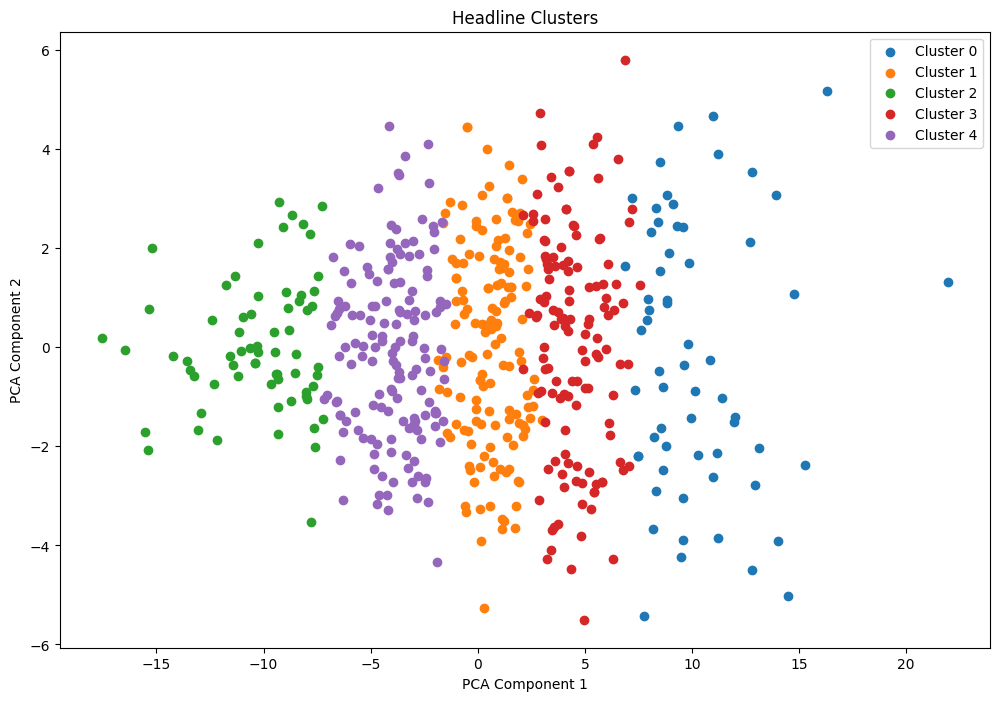

In [5]:
# scaling vectors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(headline_vectors)

# k=5 means clustering 
num_clusters = 5
km = KMeans(n_clusters=num_clusters, random_state=42)
km.fit(X_scaled)
df_clean['cluster'] = km.labels_

# PCA dimensionality reduction 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# plotting clusters
plt.figure(figsize=(12, 8))
for cluster in range(num_clusters):
    plt.scatter(X_pca[df_clean['cluster'] == cluster, 0], X_pca[df_clean['cluster'] == cluster, 1], label=f'Cluster {cluster}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Headline Clusters')
plt.legend()
plt.show()

In [6]:
# viewing examples from each cluster
for cluster in sorted(df_clean['cluster'].unique()):
    print(f"\nCluster {cluster} Sample Headlines:")
    sample_headlines = df_clean[df_clean['cluster'] == cluster]['title'].sample(5, random_state=42).tolist()
    for headline in sample_headlines:
        print(f"- {headline}")


Cluster 0 Sample Headlines:
- UK students occupy university building in protest for Palestine - Al Jazeera English
- Students protest for University action on Palestine - Daily Trojan Online
- Columbia University faculty ‘horrified’ by mass arrests of student protesters - The Guardian
- Pro-Palestinian student protest at Northeastern University in Boston cleared by police - CBS Boston
- Columbia University Closes Campus as Hundreds of Anti-Israel Student Protesters Occupy Quad - National Review

Cluster 1 Sample Headlines:
- UT-Austin professors, students protest on campus: Live updates - Austin American-Statesman
- Pro-Palestinian, Anti-Israel, Protests Spread to Yale, UMichigan, NYU and Across America - thegatewaypundit.com
- Arrested student speaks out following emergency protest - Stony Brook Statesman
- Protests, threats and the FBI: The story of FAU's inactive Students for Justice in Palestine chapter - University Press
- Berkeley professor attempts to grab mic from Palestinian 

# Wordcloud

Removed words that are less informative of each cluster

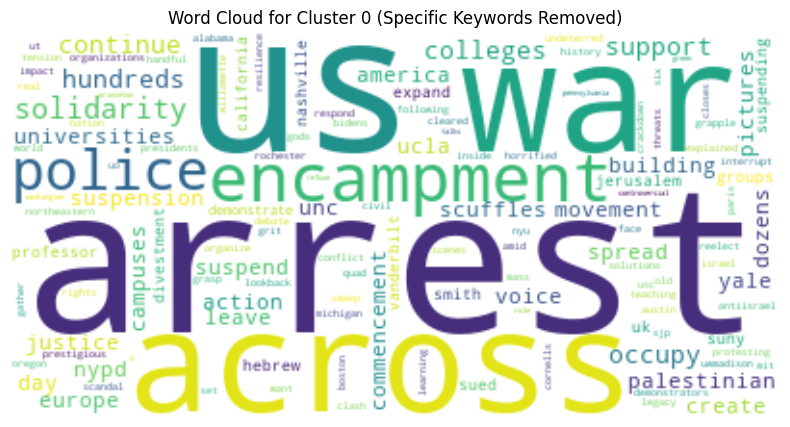

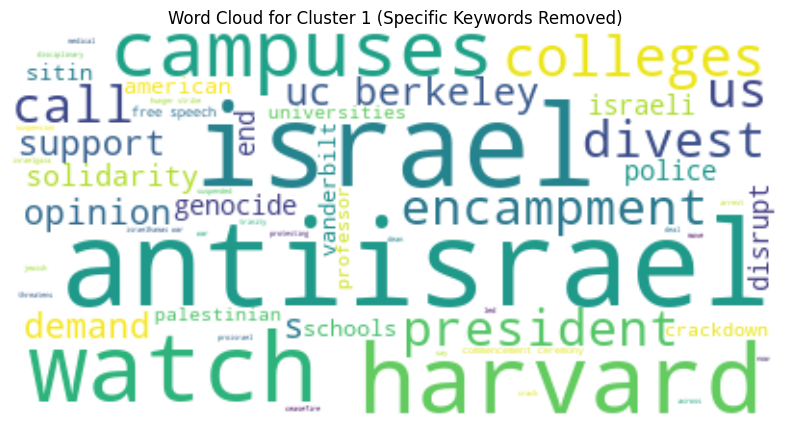

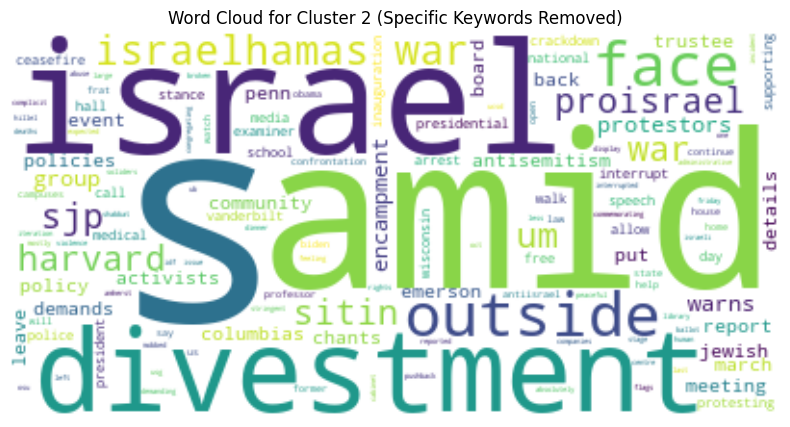

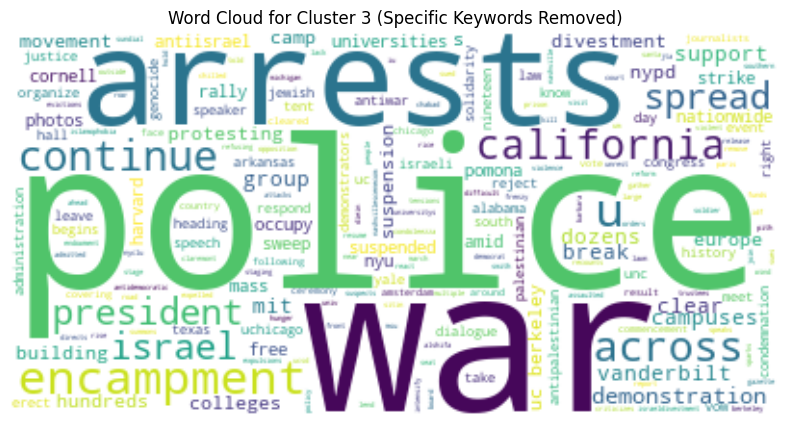

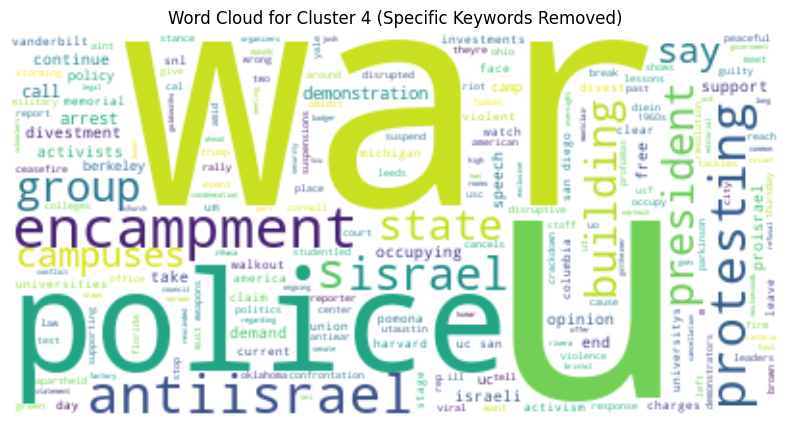

In [7]:
keywords_to_remove = {'student', 'students','university', 'college', 
                      'school', 'education', 'campus', 'class', 
                      'course', 'degree', 'faculty', 'protest', 
                     'protesters', 'protester', 'new', 'news', 'protests', 
                      'propalestinian', 'gaza', 'columbia', 'palestine', 'propalestine', 'arrested'}


for cluster_num in range(num_clusters):
    cluster_data = df_clean[df_clean['cluster'] == cluster_num]['processed_title'].tolist()
    title_list = [word for inner_lst in cluster_data for word in inner_lst]
    text = ' '.join(title_list)
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in keywords_to_remove]
    filtered_text = ' '.join(filtered_words)
    
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(filtered_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Cluster {cluster_num} (Specific Keywords Removed)')
    plt.axis('off')
    plt.show()

# Relationship Between Political Learning Score and Sentiment 

In [8]:
# reading in media bias score data
biases = pd.read_excel('../data/political_leaning.xlsx').loc[:,['news_site', 'score', 'allsides']].dropna()

biases.head()

,news_site,score,allsides
0,CNN,-0.5,-1.3
1,The Associated Press,-0.5,-1.3
4,NBC News,-0.5,-1.8
5,NBC Boston,-0.5,-1.8
6,NBC New York,-0.5,-1.8


In [9]:
# adding bias score to original df
df_bias = df_clean.merge(biases, on='news_site', how='right')
df_bias.head()

,news_site,title,date,processed_title,cluster,score,allsides
0,CNN,Students at more universities announce solidar...,2024-04-19 07:00:00+00:00,"[students, at, more, universities, announce, s...",1,-0.5,-1.3
1,CNN,"April 27, 2024 - Campus protest updates - CNN",2024-04-27 07:00:00+00:00,"[april, 27, 2024, campus, protest, updates]",2,-0.5,-1.3
2,CNN,Where pro-Palestinian university protests are ...,2024-05-03 07:00:00+00:00,"[where, propalestinian, university, protests, ...",1,-0.5,-1.3
3,CNN,"At the student protest at UPenn, passions are ...",2024-05-02 07:00:00+00:00,"[at, the, student, protest, at, upenn, passion...",3,-0.5,-1.3
4,CNN,In pictures: A lookback at student protest mov...,2024-04-30 07:00:00+00:00,"[in, pictures, a, lookback, at, student, prote...",0,-0.5,-1.3


### Visualizing Media Bias

Text(0.5, 1.0, 'Distribution of Media Bias Score')

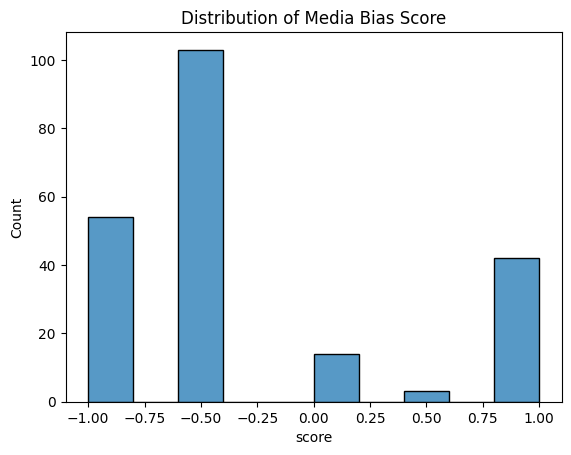

In [10]:
sns.histplot(df_bias['score'])
plt.title('Distribution of Media Bias Score')

Text(0.5, 1.0, 'Distribution of News Sites and Media Bias Scores')

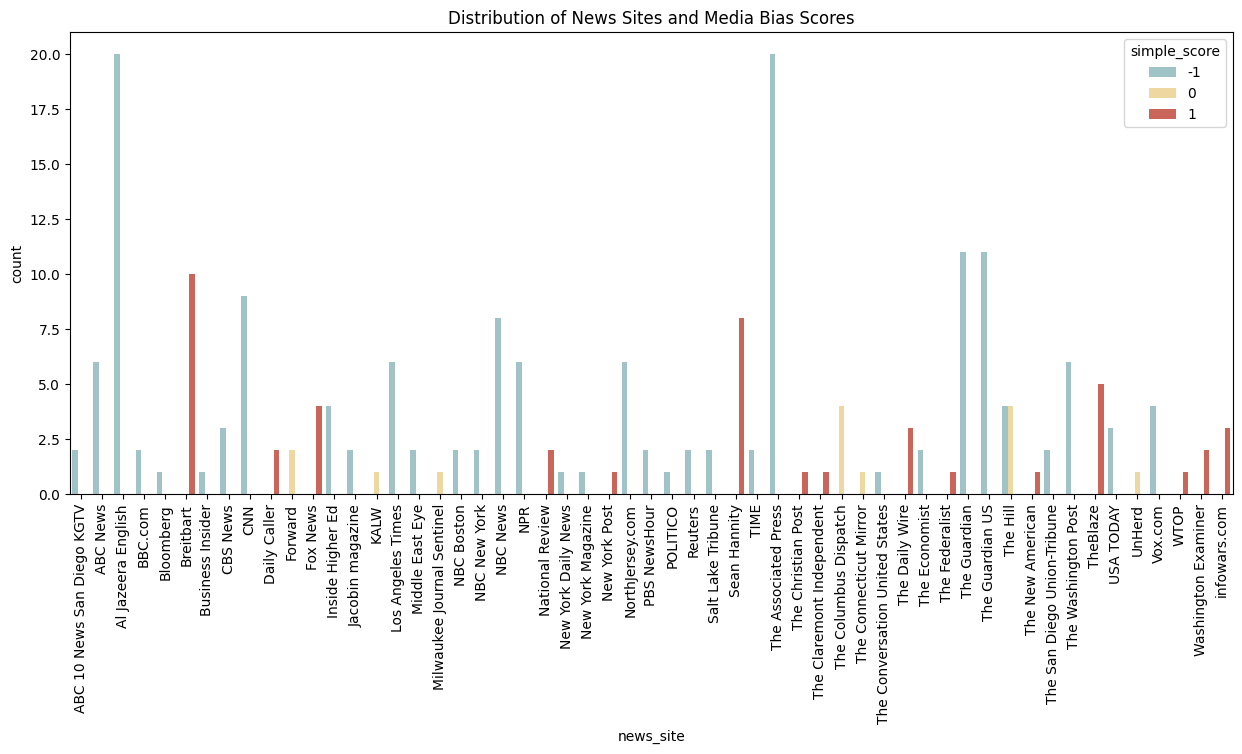

In [11]:
def get_score(score): 
    if score < 0: 
        return -1
    elif score > 0: 
        return 1
    else: 
        return 0
df_bias['simple_score'] = df_bias['score'].apply(get_score)

plt.figure(figsize=(15, 6)) 
sns.countplot(df_bias.sort_values('news_site'), x = 'news_site', hue='simple_score', palette = ['#9AC8CD', '#FCDC94', '#DD5746'])
plt.xticks(rotation=90)
plt.title('Distribution of News Sites and Media Bias Scores')

## Sentiment Analysis

In [12]:
from transformers import pipeline
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# adding sentiment score 

# hugging face
sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")

df_bias['huggingFace'] = df_bias['processed_title'].str.join(' ').apply(sentiment_analysis)
df_bias['huggingFace'] = df_bias['huggingFace'].apply(lambda x: -1 if x[0]['label'] == 'NEGATIVE' else 1)

# textBlob
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

df_bias['textBlob'] = df_bias['processed_title'].str.join(' ').apply(get_sentiment)

# VADER
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    return sia.polarity_scores(text)['compound']

df_bias['vader'] = df_bias['processed_title'].str.join(' ').apply(get_vader_sentiment)

df_bias.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/joycehu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,news_site,title,date,processed_title,cluster,score,allsides,simple_score,huggingFace,textBlob,vader
0,CNN,Students at more universities announce solidar...,2024-04-19 07:00:00+00:00,"[students, at, more, universities, announce, s...",1,-0.5,-1.3,-1,-1,0.5,-0.1621
1,CNN,"April 27, 2024 - Campus protest updates - CNN",2024-04-27 07:00:00+00:00,"[april, 27, 2024, campus, protest, updates]",2,-0.5,-1.3,-1,-1,0.0,-0.2500
2,CNN,Where pro-Palestinian university protests are ...,2024-05-03 07:00:00+00:00,"[where, propalestinian, university, protests, ...",1,-0.5,-1.3,-1,-1,0.0,-0.2263
3,CNN,"At the student protest at UPenn, passions are ...",2024-05-02 07:00:00+00:00,"[at, the, student, protest, at, upenn, passion...",3,-0.5,-1.3,-1,-1,0.1,0.5859
4,CNN,In pictures: A lookback at student protest mov...,2024-04-30 07:00:00+00:00,"[in, pictures, a, lookback, at, student, prote...",0,-0.5,-1.3,-1,1,0.0,-0.2500


Text(0.5, 1.0, 'Text Blob Sentiment')

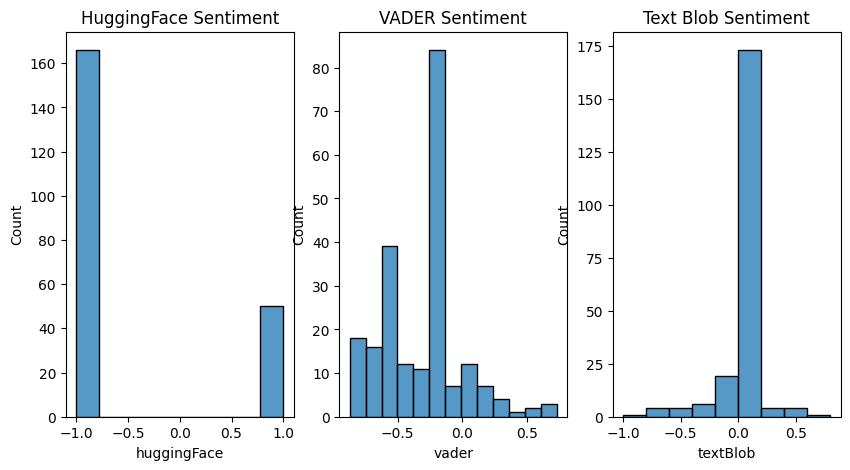

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

sns.histplot(df_bias['huggingFace'], ax=axes[0])
axes[0].set_title('HuggingFace Sentiment')

sns.histplot(df_bias['vader'], ax=axes[1])
axes[1].set_title('VADER Sentiment')

sns.histplot(df_bias['textBlob'], ax=axes[2])
axes[2].set_title('Text Blob Sentiment')

### Looking at the distribution of the three sentiment score methods, we decided to proceed with VADER. Unlike the Hugging Face model, it has a continuous distribution which would be more helpful for analysis. It also has a greater variation in scores, compared to textBlob.

In [14]:
# create binary score for some plots
df_bias['binary_sentiment'] = df_bias['vader'].apply(lambda x: 1 if x > 0 else (0 if x == 0 else -1))

Text(0.5, 1.0, 'Distribution of News Sites and Sentiment Scores')

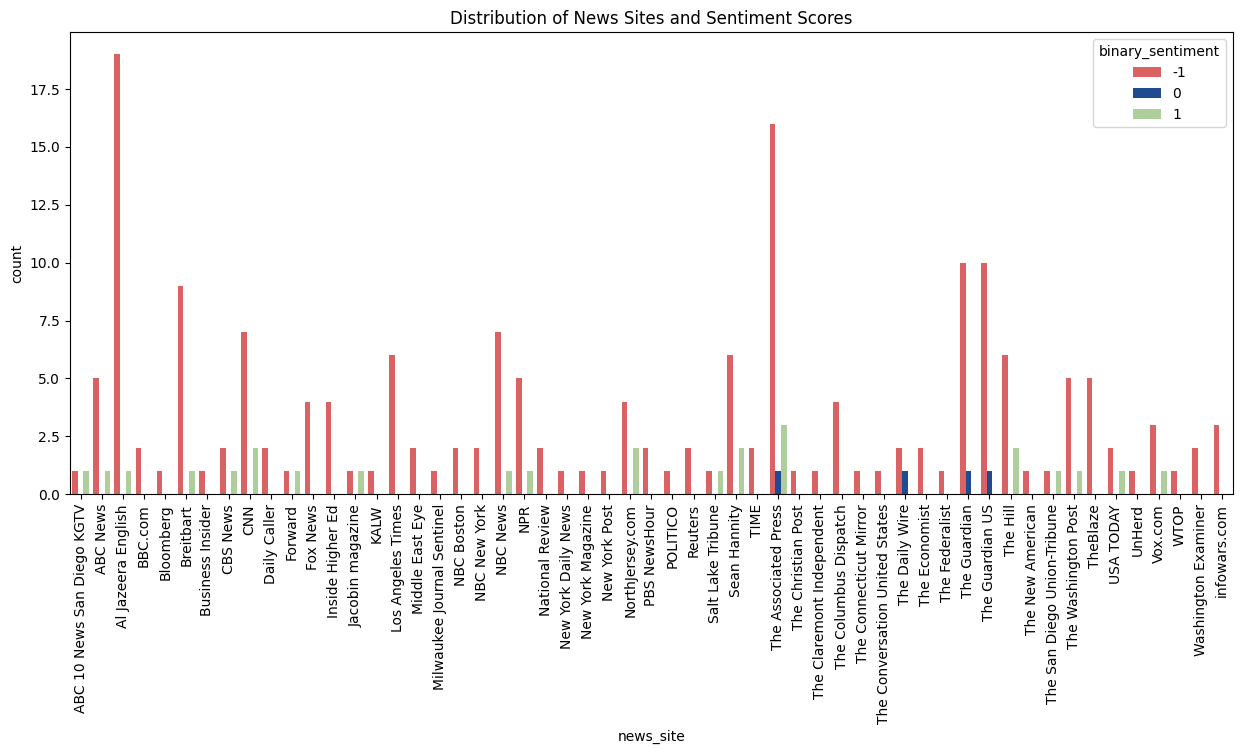

In [15]:
plt.figure(figsize=(15, 6)) 
sns.countplot(df_bias.sort_values('news_site'), x = 'news_site', hue='binary_sentiment', palette = ['#EE4E4E', '#0E46A3', '#ACD793'])
plt.xticks(rotation=90)
plt.title('Distribution of News Sites and Sentiment Scores')

Text(0.5, 0, 'Political Leaning Score')

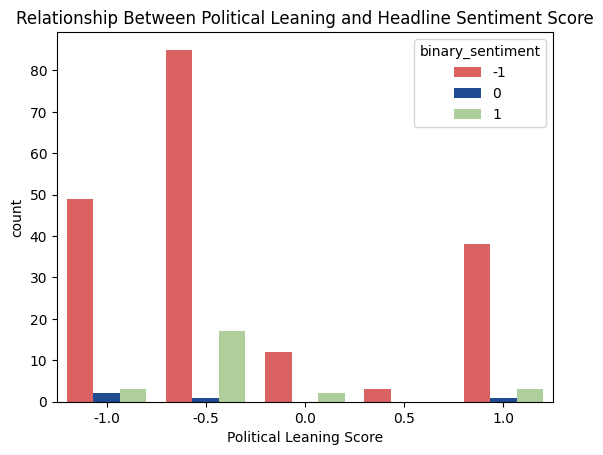

In [16]:
sns.countplot(df_bias, x = 'score', hue = 'binary_sentiment', palette = ['#EE4E4E', '#0E46A3','#ACD793'])
plt.title('Relationship Between Political Leaning and Headline Sentiment Score')
plt.xlabel('Political Leaning Score')

Text(0.5, 0, 'Political Leaning Score')

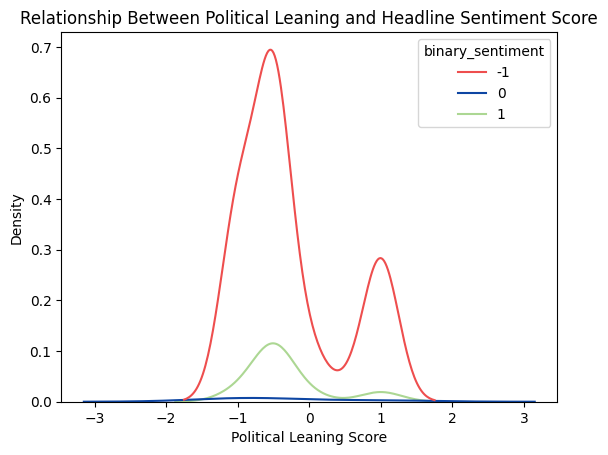

In [17]:
sns.kdeplot(df_bias, x = 'score', hue = 'binary_sentiment', palette = ['#EE4E4E', '#0E46A3','#ACD793'])
plt.title('Relationship Between Political Leaning and Headline Sentiment Score')
plt.xlabel('Political Leaning Score')


In [18]:
df_bias

,news_site,title,date,processed_title,cluster,score,allsides,simple_score,huggingFace,textBlob,vader,binary_sentiment
0,CNN,Students at more universities announce solidar...,2024-04-19 07:00:00+00:00,"[students, at, more, universities, announce, s...",1,-0.5,-1.3,-1,-1,0.5,-0.1621,-1
1,CNN,"April 27, 2024 - Campus protest updates - CNN",2024-04-27 07:00:00+00:00,"[april, 27, 2024, campus, protest, updates]",2,-0.5,-1.3,-1,-1,0.0,-0.2500,-1
2,CNN,Where pro-Palestinian university protests are ...,2024-05-03 07:00:00+00:00,"[where, propalestinian, university, protests, ...",1,-0.5,-1.3,-1,-1,0.0,-0.2263,-1
3,CNN,"At the student protest at UPenn, passions are ...",2024-05-02 07:00:00+00:00,"[at, the, student, protest, at, upenn, passion...",3,-0.5,-1.3,-1,-1,0.1,0.5859,1
4,CNN,In pictures: A lookback at student protest mov...,2024-04-30 07:00:00+00:00,"[in, pictures, a, lookback, at, student, prote...",0,-0.5,-1.3,-1,1,0.0,-0.2500,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
211,Daily Caller,California University Puts President On Leave ...,2024-05-16 07:00:00+00:00,"[california, university, puts, president, on, ...",1,1.0,3.8,1,-1,0.0,-0.2732,-1
212,infowars.com,“Situation Is Unraveling”: Pro-Palestinian Pro...,2024-04-24 07:00:00+00:00,"[“situation, is, unraveling”, propalestinian, ...",2,1.0,5.0,1,-1,0.0,-0.2263,-1
213,infowars.com,WATCH: Pro-Palestine Protesters Disrupt Univer...,2024-05-05 07:00:00+00:00,"[watch, propalestine, protesters, disrupt, uni...",1,1.0,5.0,1,-1,0.0,-0.2263,-1
214,infowars.com,WATCH: Pro-Palestine Protesters Disrupt Univer...,2024-05-05 07:00:00+00:00,"[watch, propalestine, protesters, disrupt, uni...",1,1.0,5.0,1,-1,0.0,-0.2263,-1


(array([19783., 19797., 19814., 19828., 19844., 19858.]),
 [Text(19783.0, 0, '2024-03-01'),
  Text(19797.0, 0, '2024-03-15'),
  Text(19814.0, 0, '2024-04-01'),
  Text(19828.0, 0, '2024-04-15'),
  Text(19844.0, 0, '2024-05-01'),
  Text(19858.0, 0, '2024-05-15')])

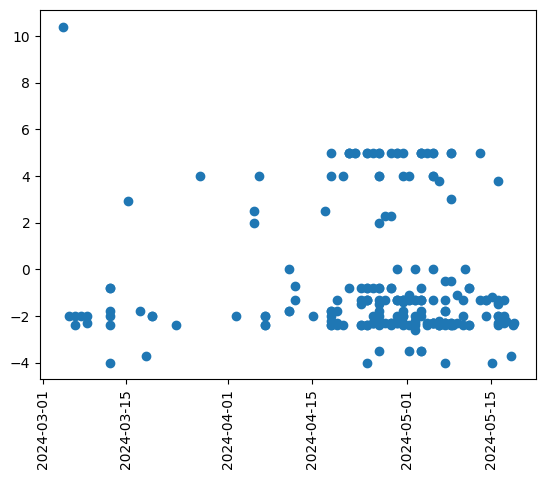

In [19]:
plt.scatter(x='date', y='allsides', data=df_bias)
plt.xticks(rotation=90)

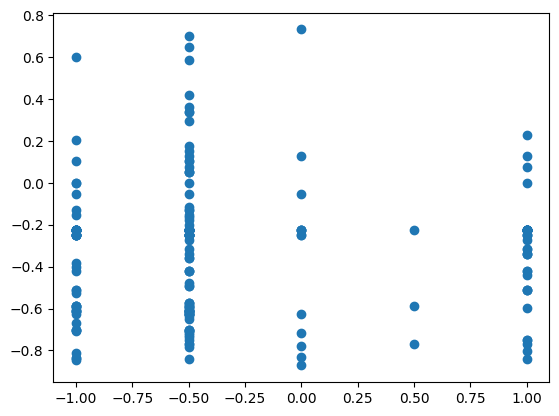

In [20]:
plt.scatter(x='score', y='vader', data=df_bias)

## Linear Regression

In [21]:
import statsmodels.api as sm

Y = df_bias['vader'].values
X = df_bias['score'].values

model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.084
Model:                            OLS   Adj. R-squared (uncentered):              0.080
Method:                 Least Squares   F-statistic:                              19.70
Date:                Wed, 12 Jun 2024   Prob (F-statistic):                    1.45e-05
Time:                        20:11:43   Log-Likelihood:                         -125.13
No. Observations:                 216   AIC:                                      252.3
Df Residuals:                     215   BIC:                                      255.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [22]:
# Trying again but with a squared term 
Y = df_bias['vader'].values
X = df_bias['score'].values

# Create the squared term
X_squared = X ** 2

# Fit the model
model = sm.OLS(Y, X_squared)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.382
Model:                            OLS   Adj. R-squared (uncentered):              0.379
Method:                 Least Squares   F-statistic:                              132.9
Date:                Wed, 12 Jun 2024   Prob (F-statistic):                    2.93e-24
Time:                        20:11:43   Log-Likelihood:                         -82.607
No. Observations:                 216   AIC:                                      167.2
Df Residuals:                     215   BIC:                                      170.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------